https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [141]:
df = pd.read_csv('Sunspots', sep="   ", header=None)

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [142]:
df.head(3)

,0,1
0,1700,0.0262
1,1701,0.0575
2,1702,0.0837


In [143]:
df.columns = ['Year', 'Spots']
df.head(3)

,Year,Spots
0,1700,0.0262
1,1701,0.0575
2,1702,0.0837


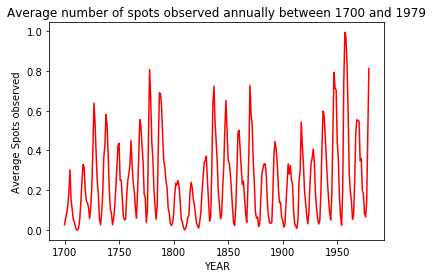

In [144]:
plt.plot(df['Year'], df['Spots'], color='r')
plt.xlabel('YEAR')
plt.ylabel('Average Spots observed')
plt.title('Average number of spots observed annually between 1700 and 1979')
plt.show()

In [145]:
df['Spots'].isna().sum()

0

In [146]:
df_training = df[0:221]
df_validation = df[210:256]
df_test = df[244:]

In [147]:
df_training.head(3)

,Year,Spots
0,1700,0.0262
1,1701,0.0575
2,1702,0.0837


In [148]:
df_validation.head(3)

,Year,Spots
210,1910,0.0973
211,1911,0.0298
212,1912,0.0188


In [149]:
df_test.head(3)

,Year,Spots
244,1944,0.0502
245,1945,0.1736
246,1946,0.4843


In [150]:
series_training = np.array(df_training['Spots'])

In [151]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12
generator_training = TimeseriesGenerator(series_training, series_training, length=n_input, batch_size=1)

In [152]:
generator_training[0]

(array([[0.0262, 0.0575, 0.0837, 0.1203, 0.1883, 0.3033, 0.1517, 0.1046,
         0.0523, 0.0418, 0.0157, 0.    ]]), array([0.]))

In [153]:
for i in range(len(generator_training)):
    x, y = generator_training[i]
    #print('%s => %s' % (x, y))

In [154]:
# define model
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=n_input))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [155]:
# fit model
model.fit_generator(generator_training, steps_per_epoch=1, epochs=2000, verbose=0)

In [156]:
# make a one step prediction out of sample
x_input = generator_training[5][0].reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)

In [157]:
yhat

array([[0.23012738]], dtype=float32)

In [158]:
series_validation = np.array(df_validation['Spots'])
generator_validation = TimeseriesGenerator(series_validation, series_validation, length=n_input, batch_size=1)
for i in range(len(generator_validation)):
    x, y = generator_validation[i]
    #print('%s => %s' % (x, y))

In [159]:
len(generator_validation)

34

In [160]:
Y_validation = []
for i in range(0,len(generator_validation)):
    x_input = generator_validation[i][0].reshape((1, n_input))
    yhat = model.predict(x_input, verbose=0)
    Y_validation = Y_validation + [yhat]
Y_valid = np.reshape(Y_validation, (34,))

In [161]:
np.reshape(Y_validation, (34,))

array([0.11499988, 0.01642825, 0.11677807, 0.09710008, 0.38077363,
       0.47709846, 0.47217032, 0.39440808, 0.30868655, 0.16838153,
       0.10565203, 0.07802948, 0.1014449 , 0.15762222, 0.27795136,
       0.47106466, 0.5716653 , 0.49191555, 0.32069892, 0.212576  ,
       0.15216208, 0.12271806, 0.07659477, 0.10885303, 0.27589414,
       0.5614753 , 0.7368275 , 0.60145783, 0.5238311 , 0.27986926,
       0.20297244, 0.12235835, 0.0306779 , 0.03499539], dtype=float32)

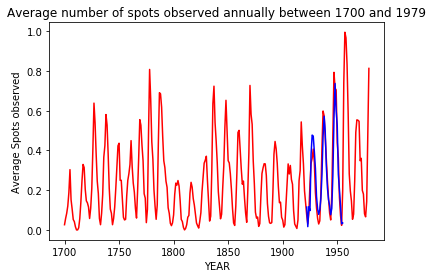

In [162]:
plt.plot(df['Year'], df['Spots'], color='r')
plt.plot(df_validation['Year'][12:47], Y_valid, color='b')
plt.xlabel('YEAR')
plt.ylabel('Average Spots observed')
plt.title('Average number of spots observed annually between 1700 and 1979')
plt.show()

In [163]:
series_test = np.array(df_test['Spots'])
generator_test = TimeseriesGenerator(series_test, series_test, length=n_input, batch_size=1)
for i in range(len(generator_test)):
    x, y = generator_test[i]
    #print('%s => %s' % (x, y))
Y_pred = []
for i in range(0,len(generator_test)):
    x_input = generator_test[i][0].reshape((1, n_input))
    yhat = model.predict(x_input, verbose=0)
    Y_pred = Y_pred + [yhat]
Y_pred = np.reshape(Y_pred, (24,))

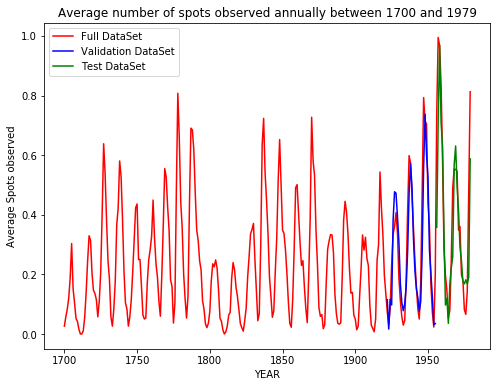

In [164]:
fig = plt.figure(figsize=(8,6))
line1 = plt.plot(df['Year'], df['Spots'], color='r')
line2 = plt.plot(df_validation['Year'][12:47], Y_valid, color='b')
line3 = plt.plot(df_test['Year'][12:], Y_pred, color='g')
plt.legend(('Full DataSet', 'Validation DataSet', 'Test DataSet'), loc='best')
plt.xlabel('YEAR')
plt.ylabel('Average Spots observed')
plt.title('Average number of spots observed annually between 1700 and 1979')
plt.show()

In [165]:
Sum_num = 0
for i in range(0, len(generator_test)):
    a = i + 12
    Sum_tmp = ((df_test['Spots'][256+i] - Y_pred[i])**2) 
    Sum_num = Sum_num + Sum_tmp

Sum_den = 0
for i in range(0, len(df['Spots'])):
    Sum_tmp = ((df['Spots'][i] - np.average(df['Spots']))**2) 
    Sum_den = Sum_num + Sum_tmp


In [166]:
ARV = Sum_num * (1 / len(generator_test)) / (Sum_den * (1 / len(df['Spots'])))

In [167]:
ARV

7.119357547503431